<a href="https://colab.research.google.com/github/DexterfreaK/XGboostUrban/blob/master/XGBoost_using_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
%pip install gdal

In [179]:
from osgeo import gdal
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
def addNaNRow(input_array):
    new_row = np.empty((1, input_array.shape[1]))
    new_row[:] = np.nan
    input_array = np.append(input_array, new_row, axis=0)

    return input_array


def addNaNCol(input_array):
    new_col = np.empty((input_array.shape[0], 1))
    new_col[:] = np.nan
    input_array = np.append(input_array, new_col, axis=1)

    return input_array

In [181]:
pathname = '/content/drive/MyDrive/AdjustedData_23_metre_Resolution/'

In [182]:
# All features in X imported and read as Array

popden = gdal.Open(pathname+"popden.tif")
popden = popden.ReadAsArray()
popden = np.where(popden < 0 , np.nan, popden)
popden = addNaNRow(popden)
popden = addNaNCol(popden)

(l,w) = popden.shape
popden = np.reshape(popden, (l*w,1))

In [183]:
Slope = gdal.Open(pathname+"slope.tif")
Slope = Slope.ReadAsArray()
Slope = np.where(Slope < 0, np.nan, Slope)
Slope = np.reshape(Slope, (l*w,1))

In [184]:
Friction = gdal.Open(pathname+"friction.tif")
Friction = Friction.ReadAsArray()
Friction = np.where(Friction < 0 , np.nan, Friction)
Friction = np.reshape(Friction, (l*w,1))

In [185]:
Elevation = gdal.Open(pathname+"elevation.tif")
Elevation = Elevation.ReadAsArray()
Elevation = np.where(Elevation < 0 , np.nan, Elevation)
Elevation = np.reshape(Elevation, (l*w,1))

In [186]:
gdp2005 = gdal.Open(pathname+"gdp2005.tif")
gdp2005 = gdp2005.ReadAsArray()
gdp2005 = np.where(gdp2005 < 0 , np.nan, gdp2005)
gdp2005 = np.reshape(gdp2005, (l*w,1))

In [187]:
gdp2011 = gdal.Open(pathname+"gdp2011.tif")
gdp2011 = gdp2011.ReadAsArray()
gdp2011 = np.where(gdp2011 < 0 , np.nan, gdp2011)

In [188]:
gdp2015 = gdal.Open(pathname+"gdp2015.tif")
gdp2015 = gdp2015.ReadAsArray()
gdp2015 = np.where(gdp2015 < 0 , np.nan, gdp2015)

In [189]:
floods = gdal.Open(pathname+"floods.tif")
floods = floods.ReadAsArray()
floods = np.where(floods < 0 , np.nan, floods)
floods = np.reshape(floods, (l*w,1))

In [190]:
accessibility = gdal.Open(pathname+"accessibilty.tif")
accessibility = accessibility.ReadAsArray()
accessibility = np.where(accessibility < 0 , np.nan, accessibility)
accessibility = np.reshape(accessibility, (l*w,1))

In [191]:
Temp2005 = gdal.Open(pathname+"Temp_2005.tif")
Temp2005 = Temp2005.ReadAsArray()
Temp2005 = addNaNRow(Temp2005)
Temp2005 = np.where(Temp2005 < 0 , np.nan, Temp2005)
Temp2005 = np.reshape(Temp2005, (l*w,1))

In [192]:
Temp2011 = gdal.Open(pathname+"Temp_2011.tif")
Temp2011 = Temp2011.ReadAsArray()
Temp2011 = addNaNRow(Temp2011)
Temp2011 = np.where(Temp2011 < 0 , np.nan, Temp2011)
Temp2011 = np.reshape(Temp2011, (l*w,1))

In [193]:
Temp2015 = gdal.Open(pathname+"Temp_2015.tif")
Temp2015 = Temp2015.ReadAsArray()
Temp2015 = addNaNRow(Temp2015)
Temp2015 = np.where(Temp2015 < 0 , np.nan, Temp2015)
Temp2015 = np.reshape(Temp2015, (l*w,1))

In [194]:
builtup_05_06 = gdal.Open(pathname+"05_06_builtup.tif")
builtup_05_06 = builtup_05_06.ReadAsArray()
builtup_05_06 = np.where(builtup_05_06 < 0 , np.nan, builtup_05_06)
builtup_05_06 = np.reshape(builtup_05_06, (l*w,1))

In [195]:
builtup_11_12 = gdal.Open(pathname+"11_12_builtup_some.tif")
builtup_11_12 = builtup_11_12.ReadAsArray()
builtup_11_12 = np.where(builtup_11_12 < 0 , np.nan, builtup_11_12)
builtup_11_12 = np.reshape(builtup_11_12, (l*w,1))

In [196]:
builtup_15_16 = gdal.Open(pathname+"15_16_builtup.tif")
builtup_15_16 = builtup_15_16.ReadAsArray()
builtup_15_16 = np.where(builtup_15_16 < 0 , np.nan, builtup_15_16)
builtup_15_16 = np.reshape(builtup_15_16, (l*w,1))

In [197]:
builtup_20_21 = gdal.Open(pathname+"20_21_builtup.tif")
builtup_20_21 = builtup_20_21.ReadAsArray()
builtup_20_21 = np.where(builtup_20_21 < 0 , np.nan, builtup_20_21)
builtup_20_21 = addNaNCol(builtup_20_21)
builtup_20_21 = np.reshape(builtup_20_21, (l*w,1))

In [198]:
#Opening and Reading Y data
# Subtracted Maps
Subtracted_Urban_11_05_data = gdal.Open(pathname+"Sub_11-05.tif")
Subtracted_Urban_11_05 = Subtracted_Urban_11_05_data.ReadAsArray()
Subtracted_Urban_11_05 = np.where(Subtracted_Urban_11_05 < 0 , 0, Subtracted_Urban_11_05)
Subtracted_Urban_11_05 = np.reshape(Subtracted_Urban_11_05, (l*w,1))

Subtracted_Urban_15_05_data = gdal.Open(pathname+"Sub_15-05.tif")
Subtracted_Urban_15_05 = Subtracted_Urban_15_05_data.ReadAsArray()
Subtracted_Urban_15_05 = np.where(Subtracted_Urban_15_05 < 0 , 0, Subtracted_Urban_15_05)
Subtracted_Urban_15_05 = np.reshape(Subtracted_Urban_15_05, (l*w,1))

Subtracted_Urban_21_11_data = gdal.Open(pathname+"Sub_21-11.tif")
Subtracted_Urban_21_11 = Subtracted_Urban_21_11_data.ReadAsArray()
Subtracted_Urban_21_11 = np.where(Subtracted_Urban_21_11 < 0 , 0, Subtracted_Urban_21_11)
Subtracted_Urban_21_11 = np.reshape(Subtracted_Urban_21_11, (l*w,1))

In [199]:
Y_array = Subtracted_Urban_15_05
X_array = builtup_05_06
Temp = Temp2005

In [200]:
assert Slope.shape == popden.shape == Friction.shape == Elevation.shape == gdp2005.shape == floods.shape == accessibility.shape ==Temp.shape
assert builtup_05_06.shape == builtup_11_12.shape == builtup_15_16.shape == builtup_20_21.shape == (l*w,1)

assert Subtracted_Urban_21_11.shape == Subtracted_Urban_11_05.shape == (l*w,1)


In [201]:
def showFeatureMaps():
  fig, axes = plt.subplots(3, 3, figsize=(40, 15))
  sns.heatmap(ax=axes[0, 0], data=Slope, square=True, cmap="crest").set_title('Kamrup Slope')
  sns.heatmap(ax=axes[0, 1], data=Elevation, square=True, cmap="crest").set_title('Kamrup Elevation')
  sns.heatmap(ax=axes[0, 2], data=Friction, square=True, cmap="crest").set_title('Kamrup Friction')
  sns.heatmap(ax=axes[1, 0], data=accessibility, square=True, cmap="crest").set_title('Kamrup Accessibility')
  sns.heatmap(ax=axes[1, 1], data=popden, square=True, cmap="crest").set_title('Kamrup Population Density')
  sns.heatmap(ax=axes[1, 2], data=Temp, square=True, cmap="crest").set_title('Kamrup Temperature')
  sns.heatmap(ax=axes[2, 0], data=floods, square=True, cmap="crest").set_title('Kamrup Floods')
  sns.heatmap(ax=axes[2, 1], data=gdp2005, square=True, cmap="crest").set_title('Kamrup GDP 2005')


In [202]:
def showBuiltupMaps():
  fig, axes = plt.subplots(2, 3, figsize=(40, 10))
  sns.heatmap(ax=axes[0,0], data=builtup_05_06, cmap="crest").set_title('Kamrup Builtip 2005-06')
  sns.heatmap(ax=axes[0,1], data=builtup_11_12, cmap="crest").set_title('Kamrup Builtip 2011-12')
  sns.heatmap(ax=axes[0,2], data=builtup_15_16, cmap="crest").set_title('Kamrup Builtip 2015-2016')
  sns.heatmap(ax=axes[1,0], data=builtup_20_21, cmap="crest").set_title('Kamrup Builtip 2020-2021')

# showBuiltupMaps()

In [203]:
Slope = np.reshape(Slope, (l*w,1))
popden = np.reshape(popden, (l*w,1))
Friction = np.reshape(Friction, (l*w,1))
Elevation = np.reshape(Elevation, (l*w,1))
floods = np.reshape(floods, (l*w,1))
accessibility = np.reshape(accessibility, (l*w,1))
previousBuiltup = np.reshape(X_array, (l*w,1))
gdp = np.reshape(gdp2005, (l*w,1))
Temp = np.reshape(Temp, (l*w,1))

Y_array = np.reshape(Y_array, (l*w,1))


In [204]:
# Converting the array data to dataframe for both X and Y
df = pd.DataFrame({
    'Slope': Slope.flatten(),
    'Elevation': Elevation.flatten(),
    'PopDen': popden.flatten(),
    'Friction': Friction.flatten(),
    'Floods': floods.flatten(),
    'Accessibility': accessibility.flatten(),
    'GDP': gdp.flatten(),
    'Previous_builtup': previousBuiltup.flatten(),
    'Temp':Temp.flatten(),
    'Y': Y_array.flatten(),
})


In [205]:
df.describe()

,Slope,Elevation,PopDen,Friction,Floods,Accessibility,GDP,Previous_builtup,Temp,Y
count,1.937682e+06,1.939210e+06,1.937869e+06,1.935703e+06,1.939194e+06,1.935918e+06,1.939170e+06,1.939268e+06,1.939176e+06,3.488477e+06
mean,8.600398e-01,8.232493e-01,1.338998e-01,8.634150e-01,8.882453e-01,7.862569e-01,1.821177e-01,1.292622e-01,5.588484e-01,2.022774e-02
std,1.367591e-01,1.472543e-01,1.862207e-01,1.828166e-01,2.511740e-01,1.607000e-01,2.751711e-01,3.354900e-01,1.685054e-01,1.407785e-01
min,7.491708e-02,0.000000e+00,0.000000e+00,1.926445e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.715124e-01,7.523553e-01,0.000000e+00,7.655186e-01,1.000000e+00,7.155893e-01,1.772051e-02,0.000000e+00,4.451104e-01,0.000000e+00
50%,9.176646e-01,9.030955e-01,5.982101e-02,9.616657e-01,1.000000e+00,8.263523e-01,4.634973e-02,0.000000e+00,5.684696e-01,0.000000e+00
75%,9.706095e-01,9.259758e-01,1.912388e-01,9.809301e-01,1.000000e+00,9.018762e-01,1.996024e-01,0.000000e+00,6.780782e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [206]:
# dropping Y from X
X = df.drop('Y', axis=1)
Y = df['Y']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .80)

In [208]:
params = {
            'max_depth': 6,
            'learning_rate': .3,
            'eval_metric':'rmsle',
            'tree_method':'gpu_hist',
        }
xgb_model=XGBRegressor(**params)
model=xgb_model.fit(X_train,y_train)

Import some metrics and checking models' score

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

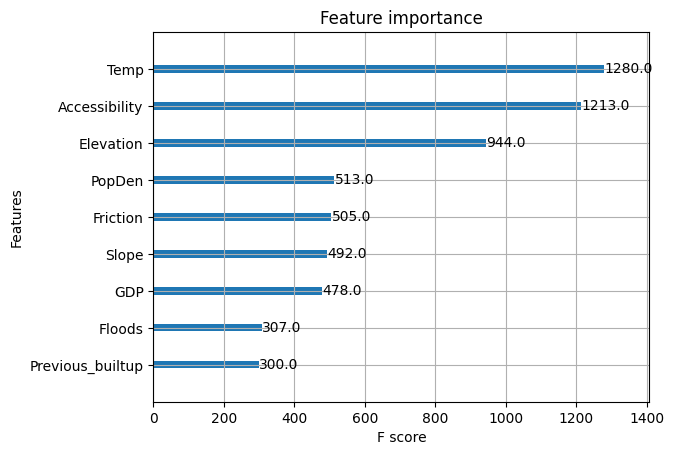

In [209]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [210]:
threshold = 0.5
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, 1)
y_pred = np.where(y_pred >= threshold, 1, 0)

y_test = y_test.astype(int)

In [211]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as MSE

print("f1_score = {}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision = {}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))
print("RMSE = {}".format(np.sqrt(MSE(y_test, y_pred))))

f1_score = 0.8792163075281447
Precision = 0.9227455618288265
Recall = 0.8441044980706786
Accuracy = 0.991436098243361
RMSE = 0.09254135160369657


**Prediction of the Urbanised Map**

In [212]:
Temp = Temp2011
Y_array = Subtracted_Urban_21_11

In [213]:
df = pd.DataFrame({
    'Slope': Slope.flatten(),
    'Elevation': Elevation.flatten(),
    'PopDen': popden.flatten(),
    'Friction': Friction.flatten(),
    'Floods': floods.flatten(),
    'Accessibility': accessibility.flatten(),
    'GDP': gdp.flatten(),
    'Previous_builtup': previousBuiltup.flatten(),
    'Temp':Temp.flatten(),
    'Y': Y_array.flatten(),
})


y_pred_2020 = model.predict(X)


Text(0.5, 1.0, 'Kamrup Urbanisation Zones Predicted')

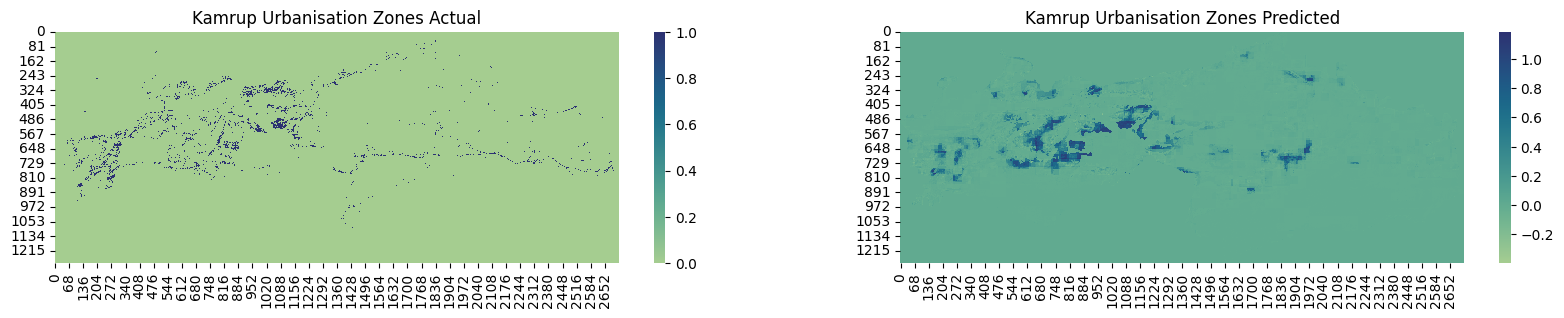

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(20, 3))
sns.heatmap(ax=axes[0], data=np.reshape(Subtracted_Urban_21_11,(l,w)), cmap="crest").set_title('Kamrup Urbanisation Zones Actual')
sns.heatmap(ax=axes[1], data=np.reshape(y_pred_2020,(l,w)).astype(np.float32), cmap="crest").set_title('Kamrup Urbanisation Zones Predicted')

In [228]:
threshold = 0.5
y_pred_2020_for_test = np.clip(y_pred_2020, 0, 1)
y_pred_2020_for_test = np.where(y_pred_2020_for_test >= threshold, 1, 0)
y_pred_2020_for_test = y_pred_2020_for_test.astype(int)

In [216]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as MSE

print("f1_score = {}".format(f1_score(Subtracted_Urban_21_11, y_pred_2020_for_test, average='macro')))
print("Precision = {}".format(precision_score(Subtracted_Urban_21_11, y_pred_2020_for_test, average='macro')))
print("Recall = {}".format(recall_score(Subtracted_Urban_21_11, y_pred_2020_for_test, average='macro')))
print("Accuracy = {}".format(accuracy_score(Subtracted_Urban_21_11, y_pred_2020_for_test)))
print("RMSE = {}".format(np.sqrt(MSE(Subtracted_Urban_21_11, y_pred_2020_for_test))))

f1_score = 0.6023188844035245
Precision = 0.598125193577939
Recall = 0.6069270660533312
Accuracy = 0.9753479813683736
RMSE = 0.15700961318220727


In [217]:
from sklearn.model_selection import GridSearchCV

clf = XGBRegressor()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "n_estimators"     : [10, 20, 30],
     'tree_method':['gpu_hist'],
     }

grid = GridSearchCV(clf, parameters, n_jobs=10, cv=3, verbose=3)

In [218]:
# grid.fit(X_train, y_train)

Converting predicted array to tiff image

In [221]:
def write_geotiff(filename, arr1, arr2,in_ds):
    if arr1.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr1.shape[1], arr1.shape[0], 2, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr1)
    band = out_ds.GetRasterBand(2)
    band.WriteArray(arr2)

    band.FlushCache()
    band.ComputeStatistics(False)

In [229]:
threshold = 0.8
y_pred_2020_for_test = np.clip(y_pred_2020, 0, 1)
y_pred_2020_for_test = np.where(y_pred_2020_for_test >= threshold, 1, 0)

In [230]:
write_geotiff('PredSome.tiff',np.reshape(y_pred_2020_for_test,(l,w)),np.reshape(builtup_11_12,(l,w)),Subtracted_Urban_21_11_data)